<a href="https://colab.research.google.com/github/chandan110791/NLP/blob/main/Eye_for_blind_Chandan_Final_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EYE FOR BLIND

This notebook will be used to prepare the capstone project 'Eye for Blind'

**Problem statement:** In this capstone project, we need to create a deep learning model which can explain the contents of an image in the form of speech through caption generation with an attention mechanism on Flickr8K dataset. This kind of model is a use-case for blind people so that they can understand any image with the help of speech. The caption generated through a CNN-RNN model will be converted to speech using a text to speech library. 

# Data preparation

In [ ]:
#Import all the required libraries

import os
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns
import collections, random, re
from collections import Counter
from PIL import Image
import glob
from sklearn.model_selection import train_test_split 
from wordcloud import WordCloud,STOPWORDS
#model building libraries
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.translate.bleu_score import sentence_bleu
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image, sequence
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.utils import pad_sequences
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers import Bidirectional
from keras.layers import add
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from tqdm import tqdm
import glob
import random
import base64
import pandas as pd
from PIL import Image
from io import BytesIO
from IPython.display import HTML
import io
import pathlib


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Data understanding



### Import the dataset and read image & captions into two seperate variables

In [ ]:
# Setting up Google Colab for usage as dataset is stored in My drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#Navigating to required DataSet folder in drive 
googleDrivePath= '/content/gdrive/MyDrive/ML/DataSets/EyeForBlind'
base_dir = pathlib.Path(googleDrivePath)
#os.chdir(str(base_dir))

In [ ]:
#copying locally and unzipping the contents

!mkdir /content/EyeForBlind
!cp "/content/gdrive/MyDrive/ML/DataSets/EyeForBlind/archive.zip" /content/EyeForBlind
dir=pathlib.Path('/content/EyeForBlind')
os.chdir(str(dir))
!unzip /content/EyeForBlind/archive.zip

mkdir: cannot create directory ‘/content/EyeForBlind’: File exists
Archive:  /content/EyeForBlind/archive.zip
replace Images/1000268201_693b08cb0e.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: None


###Read Images

In [ ]:
#Import the dataset and read the image into a seperate variable

images=os.path.join(dir,'Images')
text_file=os.path.join(dir,'captions.txt')
all_imgs = glob.glob(images + '/*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))

The total images present in the dataset: 8091


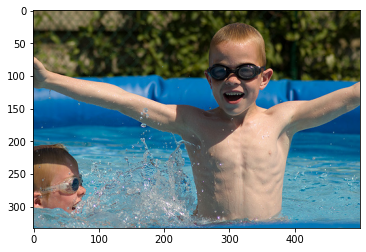

In [ ]:
#Visualise both the images & text present in the dataset

plt.imshow(mpimg.imread(all_imgs[0]))
plt.show()


### Read Captions

In [ ]:
#Import the dataset and read the text file into a seperate variable

def load_doc(filename):
    
    with open(filename,'r') as f:
        text =  list(filter(None, (line.rstrip() for line in f)))
    f.close()

    col = [line.split(",",maxsplit=1) for line in text]
    return text

doc = load_doc(text_file)
print(doc[:30])
#print(doc[1:5])


['image,caption', '1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .', '1000268201_693b08cb0e.jpg,A girl going into a wooden building .', '1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .', '1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .', '1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .', '1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting', '1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with each other on the road .', '1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots are staring at each other in the street .', '1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each other on the road .', '1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .', '1002674143_1b742ab4b8.jpg,A little girl covered in paint sits in front of a painted rainbow with her hand

### Create a dataframe which summarizes the image, path & captions as a dataframe

Till Now , we have Imported the dataset and read image & captions into two seperate variables.

Now , we create a dataframe which summarizes the image, path & captions as a dataframe .

Each image id has 5 captions associated with it therefore the total dataset should have 40455 samples.

In [ ]:
#Sanity test for doc
[i.split(',')[0] for i in doc[1:4]]


['1000268201_693b08cb0e.jpg',
 '1000268201_693b08cb0e.jpg',
 '1000268201_693b08cb0e.jpg']

In [ ]:
all_img_id=[i.split(',')[0] for i in doc[1:]] #store all the image id here
all_img_vector= [os.path.join(images,i.split(',')[0]) for i in doc[1:]] #store all the image path here
annotations= [i.split(',')[1] for i in doc[1:]]#store all the captions here

df = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['ID','Path', 'Captions']) 
    
df.head(5)

,ID,Path,Captions
0,1000268201_693b08cb0e.jpg,/content/EyeForBlind/Images/1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1,1000268201_693b08cb0e.jpg,/content/EyeForBlind/Images/1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,/content/EyeForBlind/Images/1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,/content/EyeForBlind/Images/1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .
4,1000268201_693b08cb0e.jpg,/content/EyeForBlind/Images/1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .


In [ ]:
#Setting up dataframe to diplay image and its captions
pd.set_option('display.max_colwidth', -1)
def get_thumbnail(path):
    #path = "\\\\?\\"+path # This "\\\\?\\" is used to prevent problems with long Windows paths
    i = Image.open(path)    
    return i

def image_base64(im):
    if isinstance(im, str):
        im = get_thumbnail(im)
    with BytesIO() as buffer:
        im.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()

def image_formatter(im):
    return f'<img src="data:image/jpeg;base64,{image_base64(im)}" style="max-height:124px;">'

<ipython-input-30-2ec2b27a4af8>:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [ ]:
df_img = pd.DataFrame(zip([get_thumbnail(i) for i in df.Path.head().to_list()], df.Captions.head()), columns=['Images', 'Captions'])

,Images,Captions
0,,A child in a pink dress is climbing up a set of stairs in an entry way .
1,,A girl going into a wooden building .
2,,A little girl climbing into a wooden playhouse .
3,,A little girl climbing the stairs to her playhouse .
4,,A little girl in a pink dress going into a wooden cabin .

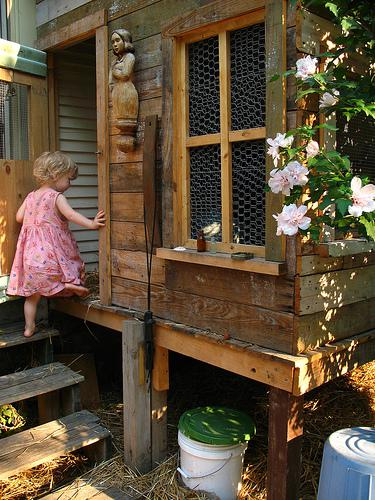
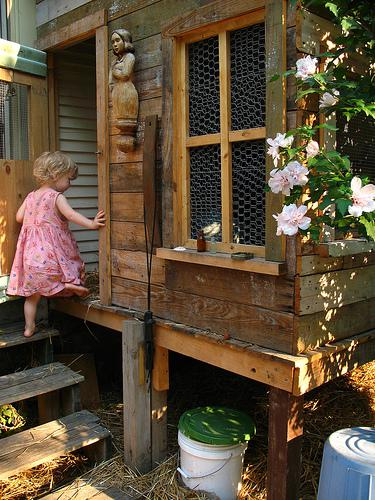
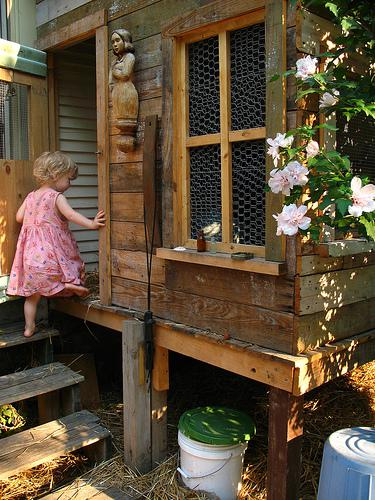
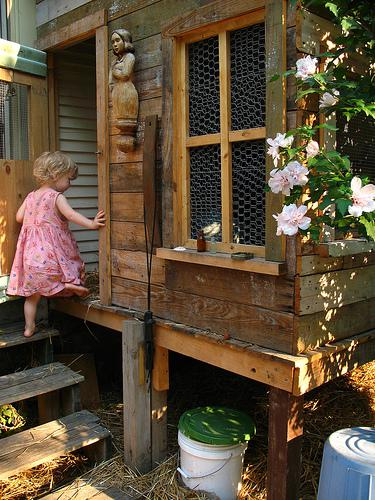
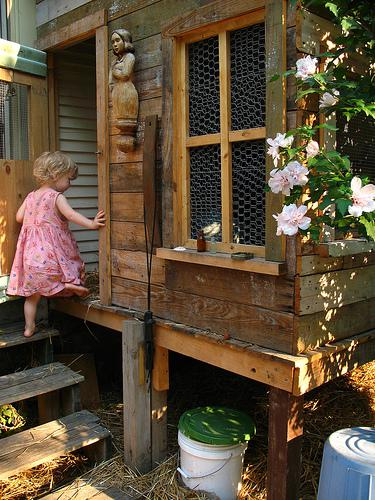

In [ ]:
#Mapping of Image and Caption

HTML(df_img.to_html(formatters={'Images': image_formatter}, escape=False))

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40455 entries, 0 to 40454
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ID        40455 non-null  object
 1   Path      40455 non-null  object
 2   Captions  40455 non-null  object
dtypes: object(3)
memory usage: 948.3+ KB


In [ ]:
# Data cleaning
# prepare translation table for removing punctuation
import string 
remove_punctuation = str.maketrans('', '', string.punctuation)
for i in range(len(annotations)):
    line = annotations[i]
    line = line.split()
    line = [word.lower() for word in line] # convert to lower case
    line = [word.translate(remove_punctuation) for word in line]# remove punctuation from each token
    line = [word for word in line if len(word)>1] # remove hanging 's' and 'a'
    line = [word for word in line if word.isalpha()]# remove tokens with numbers in them
    annotations[i]=  ' '.join(line)   # store as string

### Create a list which contains all the captions & path

In [ ]:
#Create a list which contains all the captions
#add the <start> & <end> token to all those captions as well

annotations = df.Captions.apply(lambda x:'<start> '+ x + ' <end>').to_list()

#Create a list which contains all the path to the images
all_img_path = df.Path.to_list()#write your code here

print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_img_path)))

Total captions present in the dataset: 40455
Total images present in the dataset: 40455


In [ ]:
uni_filenames= np.unique(df.ID.values)
print("The number of unique file names : {}".format(len(uni_filenames)))
print("The distribution of the number of captions for each image:", Counter(Counter(df.ID.values).values()))

The number of unique file names : 8091
The distribution of the number of captions for each image: Counter({5: 8091})


In [ ]:
#Create the vocabulary & the counter for the captions

vocabulary = []
for cap in df.Captions.values:
        vocabulary.extend(cap.split())

val_count=Counter(vocabulary)
print(f"Size of Vocab : {len(set(vocabulary))}")
print(f"Top Words in Vocab : {val_count.most_common(30)}")

Size of Vocab : 9536
Top Words in Vocab : [('a', 38716), ('.', 34205), ('A', 21480), ('in', 18170), ('the', 14587), ('on', 10354), ('is', 9069), ('and', 8057), ('dog', 7804), ('with', 7303), ('man', 6727), ('of', 6495), ('Two', 3962), ('white', 3646), ('black', 3491), ('boy', 3395), ('are', 3364), ('girl', 3174), ('woman', 3146), ('to', 3005), ('The', 2919), ('wearing', 2916), ('at', 2809), ('water', 2671), ('red', 2542), ('young', 2411), ('people', 2397), ('brown', 2383), ('his', 2255), ('blue', 2116)]


### Visualise the top 30 occuring words in the captions

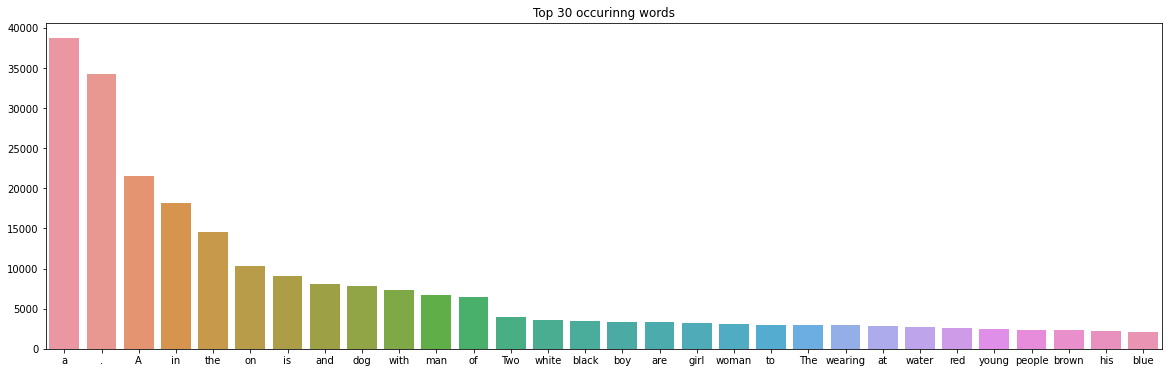

In [ ]:
sorted_list = val_count.most_common(30)

def plot_word_count(wordCountList):
    word_list,wc_list = [],[]
    for word, count in wordCountList:
        word_list.append(word)
        wc_list.append(count)
    plt.figure(figsize=(20,6))
    sns.barplot(x = word_list, y = wc_list, orient='v').set_title('Top 30 occurinng words')

plot_word_count(sorted_list)

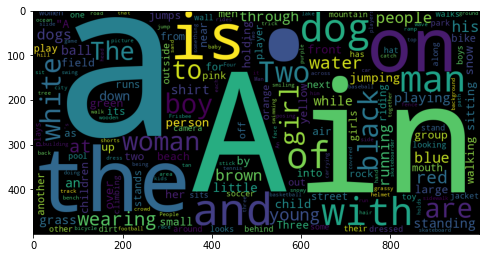

In [ ]:
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(val_count)
plt.figure(figsize=(8,8))
plt.imshow(wordcloud)


In [ ]:
# We can see that stopwords are having higher frequency.Let's find top 30 commom words excluding them.

for word, count in val_count.most_common(50):
    if word not in STOPWORDS:
        print(word, ": ", count)

dict_without_stopwords = {}
for word, count in val_count.most_common(50):
    if word not in STOPWORDS:
        dict_without_stopwords[word] = count



. :  34205
A :  21480
dog :  7804
man :  6727
Two :  3962
white :  3646
black :  3491
boy :  3395
girl :  3174
woman :  3146
The :  2919
wearing :  2916
water :  2671
red :  2542
young :  2411
people :  2397
brown :  2383
blue :  2116
dogs :  2055
running :  1995
playing :  1954
shirt :  1735
standing :  1702
ball :  1678
little :  1607
grass :  1565
child :  1449
snow :  1431
jumping :  1429
person :  1393
front :  1322
sitting :  1322
field :  1220


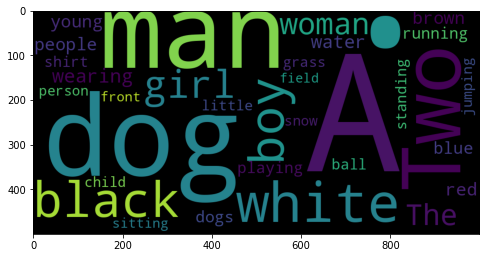

In [ ]:
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(dict_without_stopwords)
plt.figure(figsize=(8,8))
plt.imshow(wordcloud)

## Pre-Processing the captions







Create the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters..


This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

 Replace all other words with the unknown token "UNK" 

In [ ]:
# create the tokenizer and replace 

top_word_count = 5000

filter_chars = '!"#$%&()*+.,-/:;=?@[\]^_`{|}~ '
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_word_count,
                                                  oov_token="<unk>",
                                                  filters=filter_chars)
tokenizer.fit_on_texts(annotations)
train_seqs = tokenizer.texts_to_sequences(annotations)
print(train_seqs[:5])
print(annotations[:5])

[[3, 2, 44, 5, 2, 89, 173, 8, 116, 52, 2, 389, 13, 385, 5, 29, 1, 670, 4], [3, 2, 20, 313, 64, 2, 197, 120, 4], [3, 2, 39, 20, 116, 64, 2, 197, 2368, 4], [3, 2, 39, 20, 116, 6, 385, 21, 63, 2368, 4], [3, 2, 39, 20, 5, 2, 89, 173, 313, 64, 2, 197, 2887, 4]]
['<start> A child in a pink dress is climbing up a set of stairs in an entry way . <end>', '<start> A girl going into a wooden building . <end>', '<start> A little girl climbing into a wooden playhouse . <end>', '<start> A little girl climbing the stairs to her playhouse . <end>', '<start> A little girl in a pink dress going into a wooden cabin . <end>']


In [ ]:
print(f'OOV Token: {tokenizer.oov_token}')

OOV Token: <unk>


### Create word-to-index and index-to-word mappings.

In [ ]:
# Create word-to-index and index-to-word mappings.

word_index = tokenizer.word_index
index_word = tokenizer.index_word

tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

# Encode training data sentences into sequences
train_seqs  = tokenizer.texts_to_sequences(annotations)

### Visualization :Create a word count of your tokenizer to visulize the Top 30 occuring words after text processing

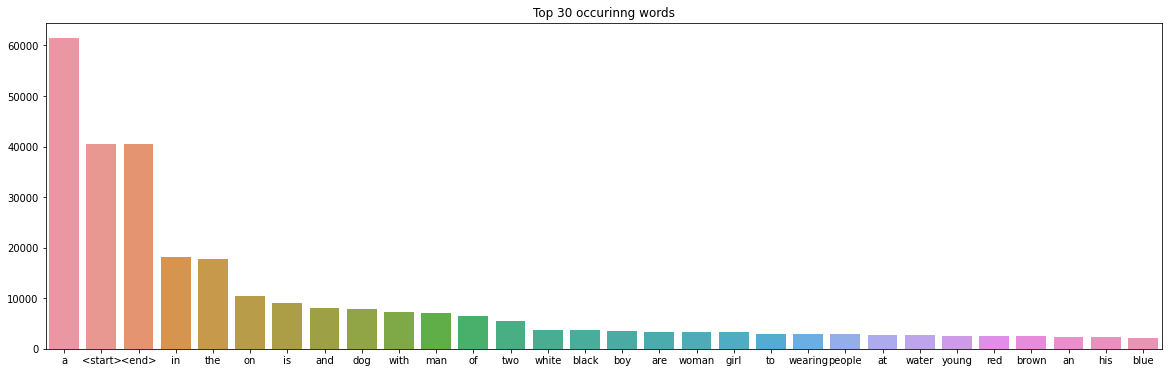

In [ ]:
# Create a word count of your tokenizer to visulize the Top 30 occuring words after text processing
sort_word_by_count = sorted(tokenizer.word_counts.items(), key=lambda kv : kv[1], reverse= True)
plot_word_count(sort_word_by_count[:30])



### Pad all sequences to be the same length as the longest one.

In [ ]:
#***
# Pad each vector to the max_length of the captions ^ store it to a vairable

max_length = max([len(t) for t in train_seqs])
print("The maximum length of a sentence in the annotation dataset is: " + str(max_length))

caption_vector = keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post', maxlen=max_length)
print("The shape of Caption vector is :" + str(caption_vector.shape))

The maximum length of a sentence in the annotation dataset is: 35
The shape of Caption vector is :(40455, 35)


## Pre-processing the images





### Resizing and Normalizing Image 

We do the below 

1.Resize images into the shape of (299, 299) .

2.Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3. 

  #### We are resizing the images as follows ::
* Since we have a list which contains all the image path, you need to first convert them to a dataset using <i>tf.data.Dataset.from_tensor_slices</i>. Once we have created a dataset consisting of image paths, we need to apply a function to the dataset which will apply the necessary preprocessing to each image. 
* This function resizes them and also should do the necessary preprocessing that it is in correct format for InceptionV3.


In [ ]:
# function returns images & their path
IMAGE_SHAPE= (299, 299)
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SHAPE)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

# Check the preprocessing Logic
print(f'Size of image before preprocessing: {mpimg.imread(all_img_vector[0]).shape}')
print(f'Size of image after preprocessing: {load_image(all_img_vector[0])[0].shape}')

Size of image before preprocessing: (500, 375, 3)
Size of image after preprocessing: (299, 299, 3)


Path - /content/EyeForBlind/Images/1007129816_e794419615.jpg
Shape after resize : (299, 299, 3)


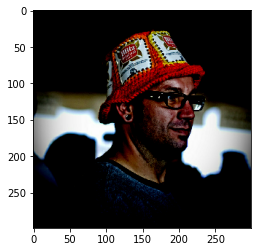

In [ ]:
#Load function test 
print("Path -",(all_img_vector[20]))
print("Shape after resize :", load_image(all_img_vector[20])[0].shape)
plt.imshow(load_image(all_img_vector[20])[0])


In [ ]:
#write your code here for applying the function to the image path dataset, such that the transformed dataset should contain images & their path
#Get unique images
all_img_vector_uniq = sorted(set(all_img_vector))

#Updating Batch Size to 64
BATCH_SIZE = 64
image_dataset = tf.data.Dataset.from_tensor_slices(all_img_vector_uniq).map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(BATCH_SIZE)

print("Unique number of Images:", len(all_img_vector_uniq))


Unique number of Images: 8091


In [ ]:
image_dataset


<BatchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>

In [ ]:
sample_img_batch, sample_cap_batch = next(iter(image_dataset))
print(sample_img_batch.shape) #(batch_size, 299, 299, 3)
print(sample_cap_batch.shape) #(batch_size, max_len)

(64, 299, 299, 3)
(64,)


## Load the pretrained Imagenet weights of Inception net V3

We do due to below reasons:

1.To save the memory(RAM) from getting exhausted, extract the features of the images using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

Along with this , We make sure the following is followed :

2.The shape of the output of this layer is 8x8x2048. 

3.Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)



### ## Loading the pretrained Inception net V3 weights

In [ ]:
#Inception V3 Model 
image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

new_input = image_model.input
hidden_layer = image_model.layers[-1].output

# Getting the Pretrained Model Weights
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

87910968/87910968 [==============================] - 5s 0us/step


In [ ]:
image_features_extract_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                           

### Apply the feature_extraction model and reshaping 

In [ ]:
# write the code to apply the feature_extraction model to your earlier created dataset which contained images & their respective paths
# Once the features are created, you need to reshape them such that feature shape is in order of (batch_size, 8*8, 2048)

image_dict = {}
from tqdm import tqdm
for img, path in tqdm(image_dataset):
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features,(batch_features.shape[0], -1, batch_features.shape[3])) ##We are sqeezing

    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        #image_dict[path_of_feature] =  bf.numpy()
        path_of_feature1 = os.path.basename(path_of_feature)
        path_of_feature2 = './'+path_of_feature1
        np.save(path_of_feature2, bf.numpy())

100%|██████████| 127/127 [00:42<00:00,  2.96it/s]


### FAQs followed to store the features:
* store the features using a dictionary with the path as the key and values as the feature extracted by the inception net v3 model OR
* *store using numpy(np.save) to store the resulting vector.*

## Dataset creation




### Apply train_test_split 

In [ ]:
# Apply train_test_split on both image path & captions to create the train & test list. Create the train-test spliit using 80-20 ratio & random state = 42
path_train, path_test, cap_train, cap_test = train_test_split(all_img_vector,caption_vector,test_size=0.2,random_state=42)

In [ ]:
print("Training data for images: " + str(len(path_train)))
print("Testing data for images: " + str(len(path_test)))
print("Training data for Captions: " + str(len(cap_train)))
print("Testing data for Captions: " + str(len(cap_test)))

Training data for images: 32364
Testing data for images: 8091
Training data for Captions: 32364
Testing data for Captions: 8091


[  3 543  10 356 140  41   4   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
<start> shepherd dog catches tennis ball <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


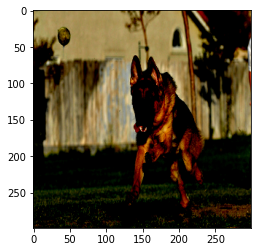

In [ ]:
# Lets see the image
print(cap_test[5])
print(" ".join(tokenizer.index_word[i] for i in cap_test[5]))
plt.imshow(load_image(path_test[5])[0])


### A function which maps the image path to their feature. 




In [ ]:
# Create a function which maps the image path to their feature. 
# This function will take the image_path & caption and return it's feature & respective caption.

def map_func(image, caption):
    #Memory utilization
    #img_tensor = image_dict[image.decode('utf-8')]
    img_name_temp = os.path.basename(image.numpy().decode('utf-8'))
    img_name_ip = './'+img_name_temp
    img_tensor = np.load(img_name_ip+'.npy') #store using numpy(np.load) to load the feature vector.
    return img_tensor, caption

### FAQs followed to load the features:
* load the features using the dictionary created earlier OR
* *store using numpy(np.load) to load the feature vector.*

### Create a builder function to create train & test dataset & apply the function created earlier to transform the dataset 



We made sure below is followed :

Make sure you have done Shuffle and batch while building the dataset

The shape of each image in the dataset after building should be (batch_size, 8*8, 2048)

The shape of each caption in the dataset after building should be(batch_size, max_len)

In [ ]:
# create a builder function to create dataset which takes in the image path & captions as input
# This function should transform the created dataset(img_path,cap) to (features,cap) using the map_func created earlier

def gen_dataset(image,caption, batch_size=32, buffer_size=1000):
    dataset = tf.data.Dataset.from_tensor_slices((image, caption))
    
    # Use map to load the numpy files in parallel
    #dataset = dataset.map(lambda item1, item2: tf.numpy_function(map_func, [item1, item2], [tf.float32, tf.int32]),num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.map(lambda item1, item2: tf.py_function(map_func, [item1, item2], [tf.float32, tf.int32]), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset


In [ ]:
#*****
BATCH_SIZE = 64
train_dataset=gen_dataset(path_train,cap_train,BATCH_SIZE)
test_dataset=gen_dataset(path_test,cap_test,BATCH_SIZE)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [ ]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape) #(batch_size, 299, 299, 3)
print(sample_cap_batch.shape) #(batch_size, max_len)


(64, 64, 2048)
(64, 35)


# Model Building
1.Set the parameters

2.Build the Encoder, Attention model & Decoder

Hyperparameters


In [ ]:
BATCH_SIZE = 32
embedding_dim = 256 
units = 512
vocab_size = 5001 #top 5,000 words +1
train_num_steps = len(path_train) // BATCH_SIZE
test_num_steps = len(path_test) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = bf.shape[1]
attention_features_shape = bf.shape[0]

### Encoder

Defining the CNN based encoder using Keras Subclassing. 

In [ ]:
class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.dense = tf.keras.layers.Dense(embed_dim)
        self.dropout = tf.keras.layers.Dropout(0.5)
        
    def call(self, features):
        # extract the features from the image shape: (batch, 8*8, embed_dim)
        features =  self.dense(features) 
        features = tf.nn.relu(features)
        
        return features

In [ ]:
encoder=Encoder(embedding_dim)

### Attention model

Defining the attention mechanism to look at the input sequences.

In [ ]:
class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units) #build your Dense layer
        self.V = tf.keras.layers.Dense(1) #build your final Dense layer with unit 1
        self.units=units

    def call(self, features, hidden):
        #features shape: (batch_size, 8*8, embedding_dim)
        # hidden shape: (batch_size, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1) # Expand the hidden shape to shape: (batch_size, 1, hidden_size)
        score = tf.keras.activations.tanh(self.W1(features) + self.W2(hidden_with_time_axis)) # build your score funciton to shape: (batch_size, 8*8, units)
        attention_weights =  tf.keras.activations.softmax(self.V(score), axis=1) # extract your attention weights with shape: (batch_size, 8*8, 1)
        context_vector = attention_weights * features #shape: create the context vector with shape (batch_size, 8*8,embedding_dim)
        context_vector = tf.reduce_sum(context_vector, axis = 1) # reduce the shape to (batch_size, embedding_dim)
        

        return context_vector, attention_weights



*   The attention model does a linear transformation of the input , now we are applying tanh function on top of it.The features produced from dense layer of encoder and hidden state of decoder are passed to tanh function and attention score is calculated .In other words, the tanh function is introduced to do non 
linear transformation and give smooth output .
*   Since we need output in range (0,1), we apply softmax function on the obtained attention score which now gives the atttention weights.
*   Now , we computed a weighted sum of the attention weights on the feature vector and thus, derived our context vector , an adaptive one as they change for each and every time stamp.

### Decoder

Defining the RNN based decoder with the attention mechanism.





In [ ]:
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(self.units) #iniitalise your Attention model with units
        self.embed = tf.keras.layers.Embedding(vocab_size, embed_dim, mask_zero =  False) #build your Embedding layer
        self.gru = tf.keras.layers.GRU(self.units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')
        self.d1 = tf.keras.layers.Dense(self.units) #build your Dense layer
        self.d2 = tf.keras.layers.Dense(vocab_size) #build your Dense layer
        self.dropout = tf.keras.layers.Dropout(0.5) #Adding Dropouts
        

    def call(self,x,features, hidden):
        context_vector, attention_weights = self.attention(features, hidden) #create your context vector & attention weights from attention model
        embed =  self.dropout(self.embed(x))# embed your input to shape: (batch_size, 1, embedding_dim)
        mask = self.embed.compute_mask(x)
        embed = tf.concat([tf.expand_dims(context_vector, 1), embed], axis=-1) # Concatenate your input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        output,state = self.gru(embed, mask) # Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) # shape : (batch_size * max_length, hidden_size)
        output = self.d2(output) # shape : (batch_size * max_length, vocab_size)
        
        return output,state, attention_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

*   The encoder output along with hidden state is passed to attention model.The attention model produces context vector.This context vector is concatenated with embedded vector formed from embedding layer and passed to GRU.
*   After passing the GRU output to dense layers,finally we are trying to obtain output in shape of vocab_size as we need to assign probabilities for each and every word in vocabulary.

In [ ]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [ ]:
features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)


Feature shape from Encoder: (64, 64, 256)
Predcitions shape from Decoder: (64, 5001)
Attention weights shape from Decoder: (64, 64, 1)


## Model training & optimization
1.We Set the optimizer & loss object

2.We Create  checkpoint path

3.We Create  training & testing step functions

4.We Create  loss function for the test dataset

In [ ]:
optimizer = tf.keras.optimizers.Adam() #define the optimizer
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE) #define your loss object

In [ ]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [ ]:
!mkdir checkpoints
#!mkdir checkpoints/train


In [ ]:
checkpoint_path = os.path.join("checkpoints","train")
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

* While creating the training step for your model, we apply **Teacher forcing**.where the target/real word is being passed as the next input to the decoder instead of previous prediciton.
* We are using teacher forcing as training converges faster. Also, in the initial steps of training, the predictions of the model would be  very bad. If we are not using it, the hidden states of the model might be updated with the sequence of wrong predictions because of the relational understading present between words, and this mislead the model as errors will keep on adding, and the model will learn wrongly and perform badly at the end.We pass the target word as the next input to the decoder

In [ ]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    #hidden = decoder.reset_state(batch_size=target.shape[0]) 
    hidden = decoder.init_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape: #Record operations for automatic differentiation for implementing backpropagation
        #write your code here to do the training steps
        encoder_output = encoder(img_tensor)

        # Using the teacher forcing technique where the target word is passed as the next input to the decoder
        for t in range(1, target.shape[1]):
          # passing encoder_output to the decoder
          predictions, hidden, _ = decoder(dec_input, encoder_output, hidden)

          loss += loss_function(target[:, t], predictions)

          dec_input = tf.expand_dims(target[:, t], 1)
    
    avg_loss = (loss / int(target.shape[1])) #we are calculating average loss for every batch

    tot_trainables_variables = encoder.trainable_variables + decoder.trainable_variables
    
    grads = tape.gradient(loss, tot_trainables_variables) # to calculate gradients with respect to every trainable variable

    #compute gradients and apply it to the optimizer and backpropagate.
    optimizer.apply_gradients(zip(grads, tot_trainables_variables)) 
        
    return loss, avg_loss

* While creating the test step for your model, you will pass your previous prediciton as the next input to the decoder.

In [ ]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    #hidden = decoder.reset_state(batch_size=target.shape[0]) #we dont have reset_state method
    hidden = decoder.init_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape: #Record operations for automatic differentiation.
        #write your code here to do the training steps
        encoder_output = encoder(img_tensor)

        # Using the teacher forcing technique where the target word is passed as the next input to the decoder.
        for t in range(1, target.shape[1]):
          # passing encoder_output to the decoder
          predictions, hidden, _ = decoder(dec_input, encoder_output, hidden)

          loss += loss_function(target[:, t], predictions) 

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, t], 1)
    
    avg_loss = (loss / int(target.shape[1]))#we are calculating average loss for every batch

    tot_trainables_variables = encoder.trainable_variables + decoder.trainable_variables

    grads = tape.gradient(loss, tot_trainables_variables) # to calculate gradients with respect to every trainable variable

    #compute gradients and apply it to the optimizer and backpropagate.
    optimizer.apply_gradients(zip(grads, tot_trainables_variables))
        
    return loss, avg_loss

In [ ]:
def test_loss_cal(test_dataset):
    total_loss = 0
    
    for (batch, (img_tensor, target)) in enumerate(test_dataset):
        batch_loss, t_loss = test_step(img_tensor, target)
        total_loss += t_loss
    avg_test_loss=total_loss/test_num_steps
    
    return avg_test_loss

In [ ]:
import sys
def sizeof_fmt(num, suffix='B'):
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:20]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                            df: 11.6 MiB
                caption_vector:  5.4 MiB
                     cap_train:  4.3 MiB
                    vocabulary:  3.7 MiB
                      cap_test:  1.1 MiB
                           doc: 342.8 KiB
                    all_img_id: 342.8 KiB
                all_img_vector: 342.8 KiB
                    train_seqs: 342.8 KiB
                   annotations: 316.1 KiB
                  all_img_path: 316.1 KiB
                     val_count: 288.1 KiB
                    word_index: 288.1 KiB
                    index_word: 288.1 KiB
                    path_train: 270.8 KiB
                      all_imgs: 65.6 KiB
                     path_test: 65.6 KiB
            sort_word_by_count: 65.1 KiB
                 uni_filenames: 63.3 KiB
           all_img_vector_uniq: 63.3 KiB


In [ ]:
tf.executing_eagerly()


True

In [ ]:
##Train for Epochs
loss_plot = []
test_loss_plot = []
EPOCHS = 15

best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps
        
    loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

  0%|          | 0/15 [00:00<?, ?it/s]

For epoch: 1, the train loss is 0.683, & test loss is 0.562
Time taken for 1 epoch 206.06994819641113 sec

Test loss has been reduced from 100.000 to 0.562


 13%|█▎        | 2/15 [04:35<27:15, 125.81s/it]

For epoch: 2, the train loss is 0.516, & test loss is 0.492
Time taken for 1 epoch 69.27309942245483 sec

Test loss has been reduced from 0.562 to 0.492


 20%|██        | 3/15 [05:45<20:03, 100.28s/it]

For epoch: 3, the train loss is 0.467, & test loss is 0.453
Time taken for 1 epoch 69.74341201782227 sec

Test loss has been reduced from 0.492 to 0.453


 27%|██▋       | 4/15 [06:55<16:09, 88.14s/it] 

For epoch: 4, the train loss is 0.433, & test loss is 0.422
Time taken for 1 epoch 69.37354707717896 sec

Test loss has been reduced from 0.453 to 0.422


 33%|███▎      | 5/15 [08:05<13:36, 81.62s/it]

For epoch: 5, the train loss is 0.406, & test loss is 0.396
Time taken for 1 epoch 69.89837074279785 sec

Test loss has been reduced from 0.422 to 0.396


 40%|████      | 6/15 [09:14<11:38, 77.56s/it]

For epoch: 6, the train loss is 0.382, & test loss is 0.374
Time taken for 1 epoch 69.51341104507446 sec

Test loss has been reduced from 0.396 to 0.374


 47%|████▋     | 7/15 [10:24<09:59, 74.99s/it]

For epoch: 7, the train loss is 0.360, & test loss is 0.352
Time taken for 1 epoch 69.50454831123352 sec

Test loss has been reduced from 0.374 to 0.352


 53%|█████▎    | 8/15 [11:34<08:32, 73.28s/it]

For epoch: 8, the train loss is 0.341, & test loss is 0.334
Time taken for 1 epoch 69.45917892456055 sec

Test loss has been reduced from 0.352 to 0.334


 60%|██████    | 9/15 [12:44<07:14, 72.35s/it]

For epoch: 9, the train loss is 0.323, & test loss is 0.316
Time taken for 1 epoch 70.12071061134338 sec

Test loss has been reduced from 0.334 to 0.316


 67%|██████▋   | 10/15 [13:54<05:57, 71.54s/it]

For epoch: 10, the train loss is 0.307, & test loss is 0.301
Time taken for 1 epoch 69.56002378463745 sec

Test loss has been reduced from 0.316 to 0.301


 73%|███████▎  | 11/15 [15:04<04:43, 70.99s/it]

For epoch: 11, the train loss is 0.292, & test loss is 0.287
Time taken for 1 epoch 69.58072018623352 sec

Test loss has been reduced from 0.301 to 0.287


 80%|████████  | 12/15 [16:13<03:31, 70.51s/it]

For epoch: 12, the train loss is 0.278, & test loss is 0.274
Time taken for 1 epoch 69.24295568466187 sec

Test loss has been reduced from 0.287 to 0.274


 87%|████████▋ | 13/15 [17:22<02:20, 70.14s/it]

For epoch: 13, the train loss is 0.264, & test loss is 0.261
Time taken for 1 epoch 69.12895464897156 sec

Test loss has been reduced from 0.274 to 0.261


 93%|█████████▎| 14/15 [18:33<01:10, 70.18s/it]

For epoch: 14, the train loss is 0.253, & test loss is 0.249
Time taken for 1 epoch 70.1078417301178 sec

Test loss has been reduced from 0.261 to 0.249


100%|██████████| 15/15 [19:42<00:00, 78.85s/it]

For epoch: 15, the train loss is 0.242, & test loss is 0.239
Time taken for 1 epoch 69.50601148605347 sec

Test loss has been reduced from 0.249 to 0.239


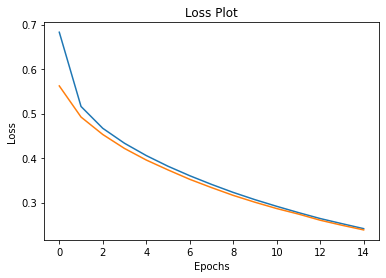

In [ ]:
#Visualize the Loss Curves
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

# Model Evaluation and Predictions
1.We Define our evaluation function using greedy search

2.We Define our evaluation function using beam search ( optional)

3.We Test it on a sample data using BLEU score

### Greedy Search

In [ ]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0) #process the input image to desired format before extracting features
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 1)
    print("dec_input Shape", dec_input.shape)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        #print("Predicted id", predicted_id)
        #print("result", tokenizer.index_word[predicted_id])

        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions

### Beam Search(optional)

In [ ]:
# Using Beam Search Evaluation
def beam_evaluate(image, beam_index = 3):
    start = [tokenizer.word_index['<start>']]
    result = [[start, 0.0]]

    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)

    while len(result[0][0]) < max_length:
        i=0
        temp = []
        for s in result:
            predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
            attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
            i=i+1
            word_preds = np.argsort(predictions[0])[-beam_index:]
          
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
            
                prob += np.log(predictions[0][w])
                    
                temp.append([next_cap, prob])
        result = temp
        result = sorted(result, reverse=False, key=lambda l: l[1])
        result = result[-beam_index:]
        
        
        predicted_id = result[-1]
        pred_list = predicted_id[0]
        
        prd_id = pred_list[-1] 
        if(prd_id!=3):
            dec_input = tf.expand_dims([prd_id], 0)  
        else:
            break
    
    
    result2 = result[-1][0]
    
    intermediate_caption = [tokenizer.index_word[i] for i in result2]
    final_caption = []
    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)
            
        else:
            break

    attention_plot = attention_plot[:len(result), :]
    final_caption = ' '.join(final_caption[1:])
    return final_caption


Visualize the attention while Caption Generation

In [ ]:
# Plotting different parts of the image which are used for captioning
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))
    
    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))
        
        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)
        
        img=ax.imshow(temp_img)
        
        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()


In [ ]:
# Removing start unk and end tag from the caption
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

## Testing the Model

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
def Testing_Model(img_test):
    #Testing on test image
    rid = np.random.randint(0, len(img_test))
    test_image = img_test[rid]
    # test_image = './images/413231421_43833a11f5.jpg'
    # real_caption = '<start> black dog is digging in the snow <end>'

    real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test[rid] if i not in [0]])
    result, attention_plot,pred_test = evaluate(test_image)
    real_caption=filt_text(real_caption)      
    pred_caption=' '.join(result).rsplit(' ', 1)[0]

    real_appn = []
    real_appn.append(real_caption.split())
    reference = real_appn
    candidate = pred_caption.split()

    print ('Real Caption      :', real_caption)
    print ('Prediction Caption:', pred_caption)
    print ('')
    score1 = sentence_bleu(reference, candidate, weights=(1,0,0,0))
    score2 = sentence_bleu(reference, candidate, weights=(0,1,0,0))
    score3 = sentence_bleu(reference, candidate, weights=(0,0,1,0))
    score4 = sentence_bleu(reference, candidate, weights=(0,0,0,1))

    print("\nBELU score: ")
    print(f"Individual 1-gram: {score1*100}")
    print(f"Individual 2-gram: {score2*100}")
    print(f"Individual 3-gram: {score3*100}")
    print(f"Individual 4-gram: {score4*100}")
    plot_attmap(result, attention_plot, test_image)
    
    return test_image, pred_caption

In [ ]:
##Function for Evaluation with Unseen Data

from PIL import Image
def Prediction_Unknown_data(test_image):
    #Testing on test image
    openImg = test_image
    print(test_image)
    #real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test[rid] if i not in [0]])
    result, attention_plot,pred_test = evaluate(test_image)
    pred_caption=' '.join(result).rsplit(' ', 1)[0]

    candidate = pred_caption.split()

    print ('Prediction Caption:', pred_caption)
    print ('')
    #plot_attmap(result, attention_plot, test_image)
    #plt.imshow(load_image(test_image)[0])
    
    im = Image.open(openImg)
    width, height = im.size
    print(width,height)
    div=3
    if width > 3000:
        div=10
    im = im.resize((width//div, height//div))
    
#    newsize = (200, 200)
    #openImg = openImg.resize(200,200)
    #return Image.open(openImg).resize(newsize)
    return im
    

### Example 1 for predicting unseen data

/content/EyeForBlind/Images/3544673666_ffc7483c96.jpg
dec_input Shape (1, 1)
Prediction Caption: a brown dog is jumping over a brick house to catch a ball

447 500


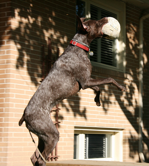

In [ ]:
Prediction_Unknown_data(path_test[13])

### Example 2 for predicting unseen data

/content/EyeForBlind/Images/270263570_3160f360d3.jpg
dec_input Shape (1, 1)
Prediction Caption: two brown dogs fight

500 461


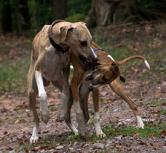

In [ ]:
Prediction_Unknown_data(path_test[1])

### Example 3 Using BLEU Score validating Testing **results**.

dec_input Shape (1, 1)
Real Caption      : a man in costume drums in a parade
Prediction Caption: a man in costume drums at a japanese flag


BELU score: 
Individual 1-gram: 66.66666666666666
Individual 2-gram: 50.0
Individual 3-gram: 42.857142857142854
Individual 4-gram: 33.33333333333333


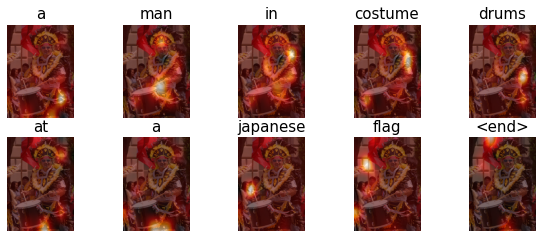

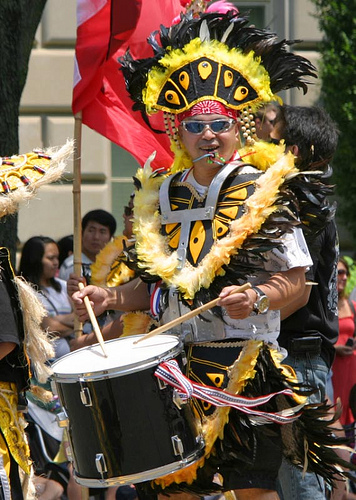

In [ ]:
test_image, pred_caption = Testing_Model(path_test)
Image.open(test_image)

In [ ]:
beam_caption=beam_evaluate(test_image)
print(beam_caption)

a man in costume drums


### Text to Speech Using Google TTS

In [ ]:
!pip install gTTS

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Libraries to convert text into audio
from gtts import gTTS
from IPython import display
#Caption to audio conversion
soundFile = 'predicted_voice_caption.mp3'

tts = gTTS(pred_caption, slow = False)
tts.save(soundFile)

display.display(display.Audio(soundFile))

### Example 4 Testing using Beam Search

two boys in a splash


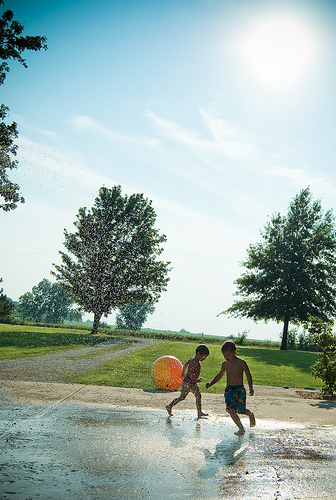

In [ ]:
# Another example of evaluate using Beam Search
from PIL import Image

test_image = "Images/1056249424_ef2a2e041c.jpg"

captions=beam_evaluate(test_image)
print(captions)
Image.open(test_image)

### Example 5 for predicting unseen data

/content/EyeForBlind/Images/195962790_3380aea352.jpg
dec_input Shape (1, 1)
Prediction Caption: a woman on with her legs to the bottom of a fountain with a small girl in the water below as a brown dog is looking at something pool

500 332


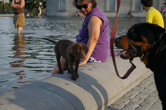

In [ ]:
# Predicting Unseen data
Prediction_Unknown_data(path_test[47])